In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import io
from tqdm import tqdm

In [2]:
# dataset path
data_root = '/home/hero/Data/heat_layout_data/200x200_0.045_0.055/simple_component/FDM'
train_list = '/hPI_UNet_NSE/ome/hero/Data/heat_layout_data/train.txt'

nse_geom_path = '/home/hero/Data/heat_layout_data/200x200_0.045_0.055/nse_geom'

In [3]:
mat1 = os.listdir(data_root + '/train')[0]
mat_file = io.loadmat(data_root + '/train/' + mat1)

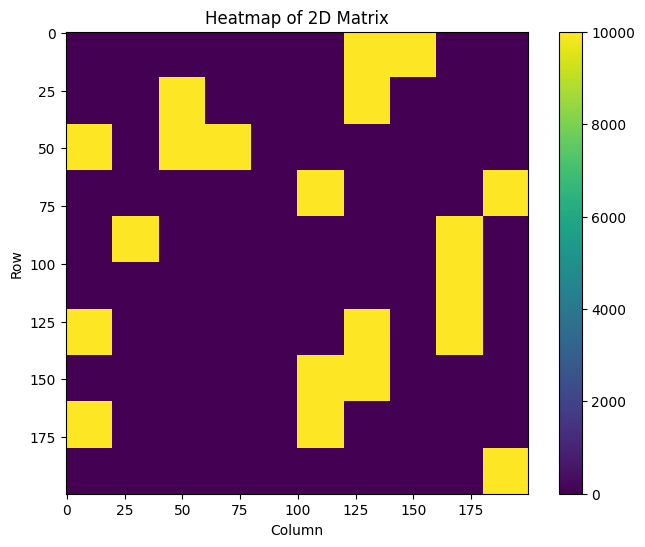

In [4]:
matrix = mat_file['F']
# 히트맵 그리기 함수
def plot_heatmap(matrix):
    plt.figure(figsize=(8, 6))
    plt.imshow(matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar()  # 색상 막대 추가
    plt.title('Heatmap of 2D Matrix')
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.show()

# 히트맵 그리기
plot_heatmap(matrix)

In [7]:
# make geometry
'''
0: interior
1: non-slip
2: inlet
3: outlet
'''

'\n0: interior\n1: non-slip\n2: inlet\n3: outlet\n'

In [6]:
mat_file['F'].shape

(200, 200)

In [7]:
def make_nse_geom(mat_file):
    geom = mat_file['F']
    # 0 1 변환
    geom[geom > 0] = 1 
    geom[0,:] = 1
    geom[-1,:] = 1
    
    # non slip,interior
    geom[:,0] = 2
    geom[:,-1] = 3

    mat_file['F'] = geom.astype('int')

    # 배열을 수직으로 스택
    nse_arr = np.stack((geom, geom, geom), axis=0)

    # inlet
    index = np.where(geom==2)
    nse_arr[0,index[0],index[1]] = 3
    nse_arr[1,index[0],index[1]] = 0
    nse_arr[2,index[0],index[1]] = 1

    # outlet
    index = np.where(geom==3)
    nse_arr[0,index[0],index[1]] = 1
    nse_arr[1,index[0],index[1]] = 1
    nse_arr[2,index[0],index[1]] = 0

    mat_file['u'] = nse_arr.astype('int')
    
    return mat_file

In [29]:
mat_nse = make_nse_geom(mat_file)

In [30]:
mat_nse['F'].shape, mat_nse['u'].shape

((200, 200), (3, 200, 200))

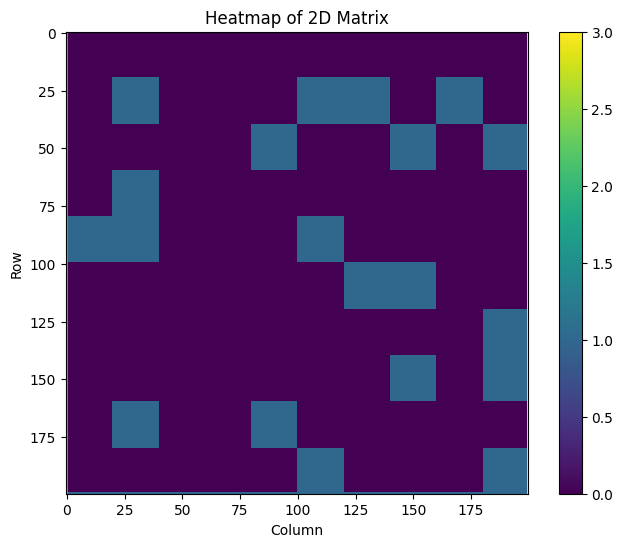

In [15]:
plot_heatmap(mat_nse['F'])

In [10]:
heat = np.ones([16,3,200,200])
layout=mat_nse['F']
G = np.ones_like(heat)
layout[layout>0] = 1
print(layout.shape)
G[...,2,:,:] = G[...,2,:,:]*layout
print(G[...,2,:,:].shape)

(200, 200)
(16, 200, 200)


In [12]:
for mat1 in tqdm(os.listdir(data_root + '/train')):
    mat_file = io.loadmat(data_root + '/train/' + mat1)
    mat_nse = make_nse_geom(mat_file)

    io.savemat(nse_geom_path + '/train/' + mat1,mat_nse)

100%|██████████| 10000/10000 [00:39<00:00, 250.11it/s]
